<a href="https://colab.research.google.com/github/Ruphai/UBS/blob/main/UAV.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img align="left" style="padding-right:10px;" src="https://www.plus.ac.at/wp-content/uploads/2021/03/cde_titelbild.jpg" width=30% >
<img align="right" style="padding-left:10px;" src="https://www.univ-ubs.fr/skins/UBS/resources/img/logo.png" width=12% >

<center>
Université de Bretagne Sud - Copernicus Master for Digital Earth <br> 
Lecture 07: UAV<br> 
Thomas Houet and Antoine Collin<br> 
<h1> <b>Lab assignment: UAV Image classification </b></h1>
</center>

Students: **Cesar Aybar and Rufai Balogun**

Program: Copernicus Digital Earth

Code: e2008986 and e2008985



### **Introduction**
In this analysis, we evaluated the performance of different classification algorithm and the influence of different imaging sensors discriminating land cover classes in images collected over the coastal area of the Lancieux beach area in Dinard France. The images were collected with a DJI drone with a RGB and Red Edge Sensor on-board on the 24th of November 2021. These images were orthorectified and used to create the Orthomosaic of each of the multi-layered images obtained from the imaging sensor and used in this classification tasks. The influence of each of these sensors (RGB, NIR and Red Edge) in improving the discrimination of classes were studied by generating multiple stacks of the image layers using and noted.

This analysis was implemented in the following steps, shown in this notebook: 
- Generation of orthophotos using Agisoft, 
- Generation of image stacks using QGIS,
- Selection of training sets using QGIS, 
- Visualization of the class balance/imbalance in the training sets,
- Model training and prediction, and 
- Accuracy assessment.

We selected the Gradient Boosting Algorithm for this classification task due it's high performance and speed when dealing with complex data, like we have in our case. The model was tested on three different combination of the output of the imaging sensors:
- **RGB stack,** 
- **RGB + DSM stack,** 
- **RGB + NIR stack,** 
-	**RGB + NIR + Red Edge,  and**
- **RGB + DSM + NIR + RedEdge**

**NOTE:** In pre-processing the images for classification, each of the images were set to the same resolution and extent. **This report is 100% reproducible**


#### **Workspace utilities**

In [ ]:
!pip install rasterio

In [ ]:
%matplotlib inline
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import os
import rasterio

In [ ]:
#@title **1. Download the UAV images**
import requests
import zipfile

# Mount drive to allow Colab to access to your Google Drive
def download_file_from_google_drive(id, destination):
    URL = "https://docs.google.com/uc?export=download"

    session = requests.Session()

    response = session.get(URL, params = { 'id' : id }, stream = True)
    token = get_confirm_token(response)

    if token:
        params = { 'id' : id, 'confirm' : token }
        response = session.get(URL, params = params, stream = True)

    save_response_content(response, destination)    

def get_confirm_token(response):
    for key, value in response.cookies.items():
        if key.startswith('download_warning'):
            return value

    return None

def save_response_content(response, destination):
    CHUNK_SIZE = 32768

    with open(destination, "wb") as f:
        for chunk in response.iter_content(CHUNK_SIZE):
            if chunk: # filter out keep-alive new chunks
                f.write(chunk)

# Download files
file_id = '1-BDWM0D9XkDw40TNAfbAEITChqpnOVVk'
destination = '/content/data.zip'
download_file_from_google_drive(file_id, destination)
directory_to_extract_to = '/content/data/'
with zipfile.ZipFile(destination, 'r') as zip_ref:
    zip_ref.extractall(directory_to_extract_to)


file_id = '1x9wqpdRP49HFDKOdiOFQ20ErLQ56SeYF'
destination = '/content/train_dataset.csv'
download_file_from_google_drive(file_id, destination)


file_id = '1kDFbAi7dcKR9yPO2-d-BythB4mPPISS6'
destination = '/content/total_img.tif'
download_file_from_google_drive(file_id, destination)

### **2. Load images**

In [ ]:
# RGB
with rasterio.open("data/ortho.tif") as r:
  rgb_r = np.moveaxis(r.read(), 0, 2)

# NIR
with rasterio.open("data/NIR_Ortho.tif") as r:
  nir_r = np.moveaxis(r.read(), 0, 2).squeeze()

# DSM
with rasterio.open("data/rgb_dsm.tif") as r:
  dsm_r = (np.moveaxis(r.read(), 0, 2).squeeze())[:, :, 3]
  
# rEdge
with rasterio.open("data/reg_orthomosaic.tif") as r:
  redge_r = (np.moveaxis(r.read(), 0, 2).squeeze())  

### **3. Visualize images**


Text(0.5, 1.0, 'Red Edge Orthomosaic')

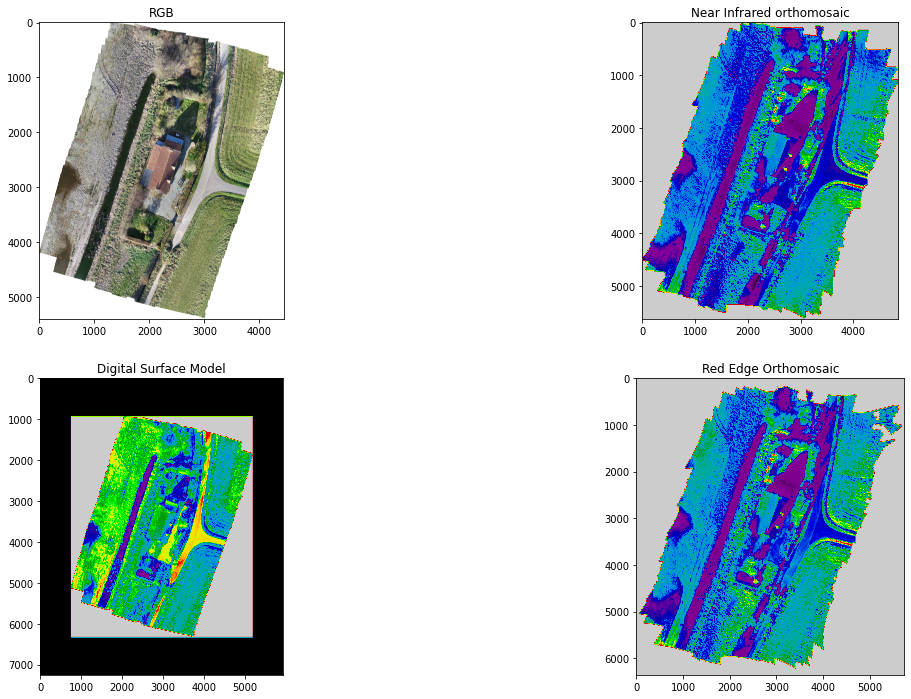

In [ ]:
fig, axs = plt.subplots(2, 2, figsize = (20, 12))

axs[0, 0].imshow(rgb_r)
axs[0, 0].set_title("RGB")

axs[0, 1].imshow(nir_r, cmap='nipy_spectral')
axs[0, 1].set_title("Near Infrared orthomosaic")

axs[1, 0].imshow(dsm_r, cmap='nipy_spectral')
axs[1, 0].set_title("Digital Surface Model")

axs[1, 1].imshow(redge_r, cmap='nipy_spectral')
axs[1, 1].set_title("Red Edge Orthomosaic")

### 4. **Load Target**
*The classes were created based on human visual interpretation*

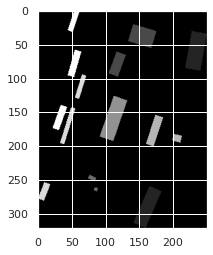

In [ ]:
classes = {1: 'Grass', 2: 'Bush', 3: 'Tree', 4: 'Roof', 5: 'Road', 6: 'Water', 7: 'Sediment'}

with rasterio.open("data/raster_train.tif") as r:
  trainset = np.moveaxis(r.read(), 0, 2).squeeze()  
plt.imshow(trainset, cmap = 'gray')

In [ ]:
classes = {1: 'Grass', 2: 'Bush', 3: 'Tree', 4: 'Roof', 5: 'Road', 6: 'Water', 7: 'Sediment'}
bins = np.unique(trainset[trainset>0])
classes = [classes[i] for i in bins]
classes

['Grass', 'Bush', 'Tree', 'Roof', 'Road', 'Water', 'Sediment']

### **5. Target classes distribution**

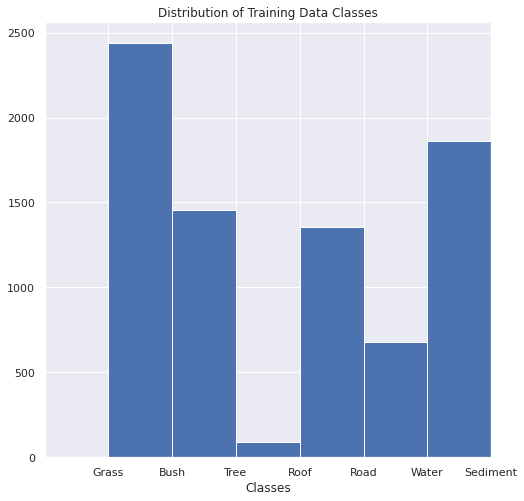

In [ ]:
def bins_labels(bins, **kwargs):
    '''center the histogram bin labels due to OCD'''
    bin_w = (max(bins) - min(bins)) / (len(bins) - 1)
    #plt.xticks(np.arange(min(bins)+bin_w/2, max(bins), bin_w), bins, **kwargs)
    plt.xlim(bins[0], bins[-1])

def statsdata(arr):
    '''generate histogram of training data'''
    fig=plt.figure(figsize=(8, 8))
    bins = range(8)
    plt.hist(arr, bins=bins)  # arguments are passed to np.histogram
    bins_labels(bins, fontsize=20)
    plt.title('Distribution of Training Data Classes')
    plt.xlabel('Classes')
    classes = {1: 'Grass', 2: 'Bush', 3: 'Tree', 4: 'Roof', 5: 'Road', 6: 'Water', 7: 'Sediment'}
    bins = np.unique(trainset[trainset>0])
    classes = [classes[i] for i in bins]
    plt.xticks(bins, labels = classes)

statsdata(trainset[trainset>0].ravel())

### **6. Train and Test a ML dataset**

In [ ]:
#@title **Gradient Boosting Model**
def train_test_model(X_train, X_test, y_train, y_test):
    # Load the datasets
    lgb_train = lgb.Dataset(X_train, y_train)
    lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train)


    # specify your configurations as a dict
    params = {
        'boosting_type': 'gbdt',
        'objective': 'softmax',
        'metric': {'softmax'},
        'num_class': 7,
        'num_leaves': 31,
        'learning_rate': 0.1,
        'feature_fraction': 0.9,
        'bagging_fraction': 0.8,
        'bagging_freq': 5,
        'verbose': -1,
        'seed': 100,
    }

    # Train a Gradient Boosting Decision Tree
    gbm = lgb.train(params,
                    lgb_train,
                    num_boost_round=5000,
                    verbose_eval=False,
                    valid_sets=lgb_eval,                    
                    early_stopping_rounds=10)
    gbm.save_model('best_model.txt')

    # Test the model 
    gbm = lgb.Booster(model_file='best_model.txt')
    y_pred = gbm.predict(X_test, num_iteration=gbm.best_iteration)

    cm_test = confusion_matrix(y_test, np.argmax(y_pred, axis=1))
    acc_test = accuracy_score(y_test, np.argmax(y_pred, axis=1))
    
    # print(cm_test)
    # print("\n")
    # print(f'The global acc of prediction is: {acc_test}')    

    return gbm, acc_test, cm_test

def plotImp(model, X , num = 20, fig_size = (40, 20)):
    feature_imp = pd.DataFrame({'Value':model.feature_importance(),'Feature':X.columns})
    plt.figure(figsize=fig_size)
    sns.set(font_scale = 1)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", 
                                                        ascending=False)[0:num])
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()
    plt.savefig('lgbm_importances-01.png')
    plt.show()

def create_dataset(bands = "r+g+b+nir+dsm+r2"):
    dataset = pd.read_csv("train_dataset.csv")[["Unnamed: 0", "r", "g", "b", "nir", "dsm", "r2"]]    
    dataset.columns = ["r", "g", "b", "nir", "dsm", "r2", "target"]

    bands_to = bands.split("+")
    indeces = {"r": 0, "g": 1, "b": 2, "nir": 3, "dsm": 4, "r2": 5, "target": 6}
    fbands = [indeces[band] for band in bands_to]
        
    dataset.target = dataset.target - 1
    Train_db, Test_db = dataset.iloc[:, fbands], dataset.iloc[:, 6]
    X_train, X_test, y_train, y_test = train_test_split(Train_db, Test_db, test_size=0.1, random_state=65)
    return X_train, X_test, y_train, y_test    

def predict_image(features):  
    img_flatten = np.array(
      [
        features[:,:,0].flatten(),
        features[:,:,1].flatten(),
        features[:,:,2].flatten(),
        features[:,:,3].flatten(),
        features[:,:,4].flatten(),
        features[:,:,5].flatten()
      ]
    )
    prediction_values = np.argmax(model.predict(np.swapaxes(img_flatten, 0, 1)), axis=1)
    prediction_values = prediction_values.reshape(250, 322).T
    return prediction_values

def Trainer(bands="r+g+b"):
    # 1. Create dataset
    X_train, X_test, y_train, y_test = create_dataset(bands)

    # 2. Evaluate your model in local (usi"ng ligthgbm)
    model = train_test_model(X_train, X_test, y_train, y_test)

    return model

def Predict(model, image = "total_img.tif"):
    # 3 Predict
    with rasterio.open(image) as r:
      total_img = np.swapaxes(r.read(), 2, 0)
    img_class = predict_image(total_img)
    return img_class

def plot_predict(img_class):
  values = np.unique(img_class.ravel())
  
  classes = {0: 'Grass', 1: 'Bush', 2: 'Tree', 3: 'Roof', 4: 'Road', 5: 'Water', 6: 'Sediment'}
  final_classes = [i for i in [classes[i] for i in values] ]
  
  plt.figure(figsize = (20, 12))
  im = plt.imshow(final_pred)
  
  colors = [im.cmap(im.norm(value)) for value in values]
  patches = [ mpatches.Patch(color=colors[i], label="{l}".format(l=final_classes[i]) ) for i in range(len(final_classes))]
  plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0. )
  plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
import lightgbm as lgb
import seaborn as sns
import pandas as pd

#### **Test Gradient Boost Model on the RGB stack**

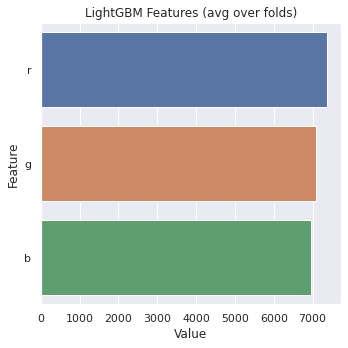

In [ ]:
#1. Create dataset
# available: ["r", "g", "b", "nir", "dsm", "r2"]
X_train, X_test, y_train, y_test = create_dataset(bands = "r+g+b")

# 2. Evaluate your model in local (using ligthgbm)
model, accuracy, cm = train_test_model(X_train, X_test, y_train, y_test)

# 3. Evaluate your model using ligthgbm
plotImp(model, X_train, num = 10, fig_size = (5, 5))

# 4. Predict
final_pred_RGB = Predict(model)

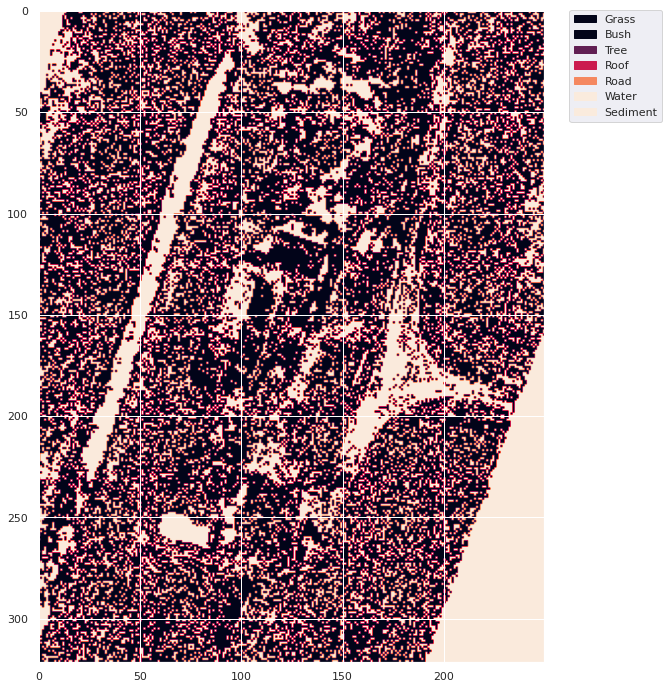

In [ ]:
plot_predict(final_pred_RGB)

In [ ]:
print(f'The global acc of prediction is: {accuracy}') 

The global acc of prediction is: 0.7842639593908629


In [ ]:
labels = ['Grass', 'Bush', 'Tree', 'Roof', 'Road', 'Water', 'Sediment']

df_cm = pd.DataFrame(cm, index = labels,
                  columns = labels)
df_cm

Grass  Bush  Tree  Roof  Road  Water  Sediment
Grass       221    18     0     1     0      0         0
Bush         38    83     0     6     1     12        11
Tree          4     4     0     0     0      0         0
Roof          3     5     0   114     0      0         4
Road          0     0     0     0    69      0        12
Water         0    14     0     1     0     68         1
Sediment      0    11     0     2    21      1        63

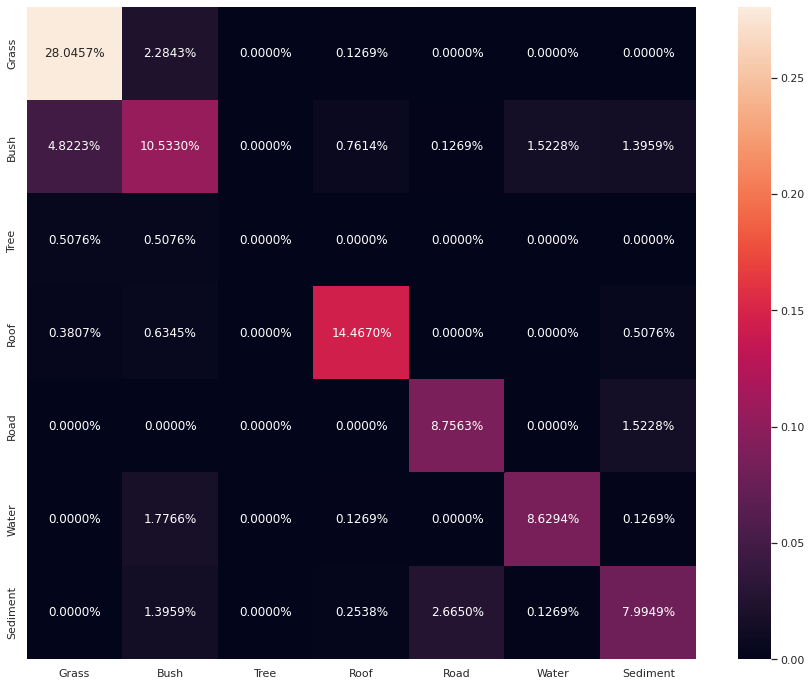

In [ ]:
import seaborn as sns
import pandas as pd
plt.figure(figsize = (15, 12))
sns.heatmap(df_cm/np.sum(cm), fmt='.4%', annot=True)

#### **Test Gradient Boost Model on the RGB+NIR stack**

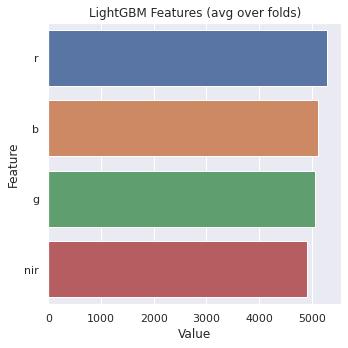

In [ ]:
#1. Create dataset
# available: ["r", "g", "b", "nir", "dsm", "r2"]
X_train, X_test, y_train, y_test = create_dataset(bands = "r+g+b+nir")

# 2. Evaluate your model in local (using ligthgbm)
model, accuracy, cm = train_test_model(X_train, X_test, y_train, y_test)

# 3. Evaluate your model using ligthgbm
plotImp(model, X_train, num = 10, fig_size = (5, 5))

# 4. Predict
final_pred_RGBNIR = Predict(model)

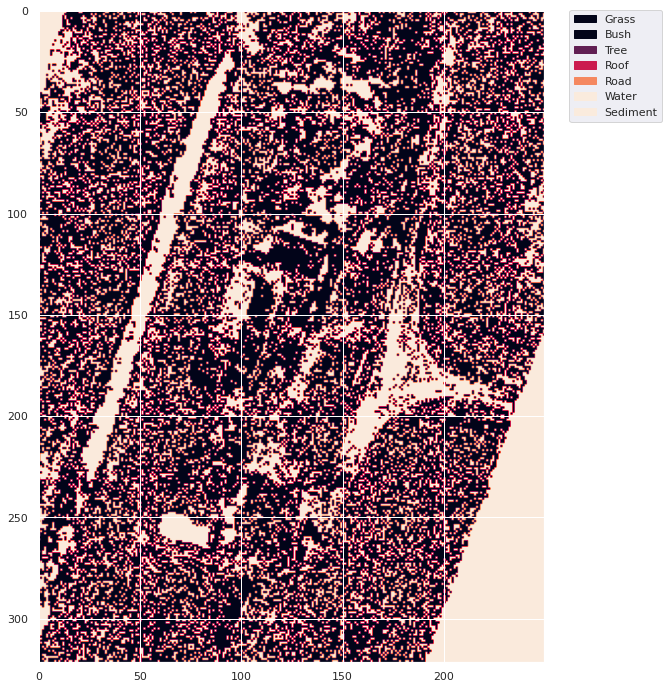

In [ ]:
plot_predict(final_pred_RGBNIR)

In [ ]:
print(f'The global acc of prediction is: {accuracy}')

The global acc of prediction is: 0.8375634517766497


In [ ]:
labels = ['Grass', 'Bush', 'Tree', 'Roof', 'Road', 'Water', 'Sediment']
df_cm = pd.DataFrame(cm, index = labels,
                  columns = labels)
df_cm

Grass  Bush  Tree  Roof  Road  Water  Sediment
Grass       230     9     1     0     0      0         0
Bush         27    99     1     8     1      9         6
Tree          5     3     0     0     0      0         0
Roof          1     5     1   115     0      1         3
Road          0     0     0     0    70      1        10
Water         0     8     0     0     0     75         1
Sediment      1     8     0     4    14      0        71

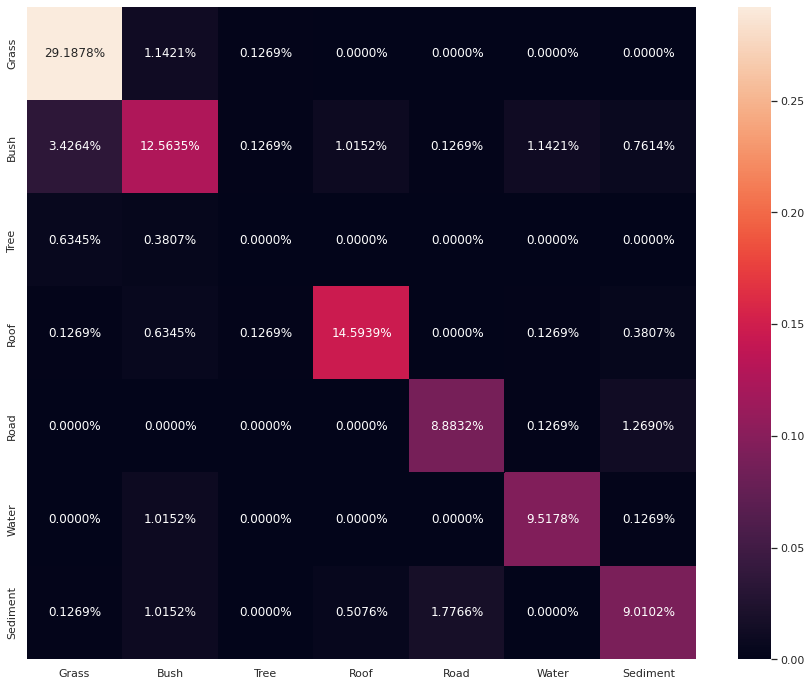

In [ ]:
plt.figure(figsize = (15, 12))
sns.heatmap(df_cm/np.sum(cm), fmt='.4%', annot=True)

#### **Test Gradient Boost Model on the RGB+DSM stack**

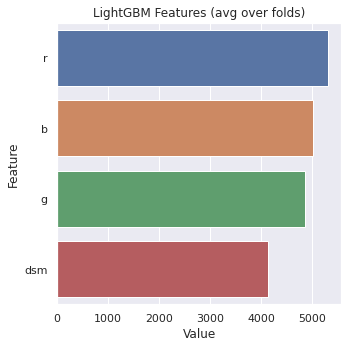

In [ ]:
#1. Create dataset
# available: ["r", "g", "b", "nir", "dsm", "r2"]
X_train, X_test, y_train, y_test = create_dataset(bands = "r+g+b+dsm")

# 2. Evaluate your model in local (using ligthgbm)
model, accuracy, cm = train_test_model(X_train, X_test, y_train, y_test)

# 3. Evaluate your model using ligthgbm
plotImp(model, X_train, num = 10, fig_size = (5, 5))

# 4. Predict
final_pred_RGBDSM = Predict(model)

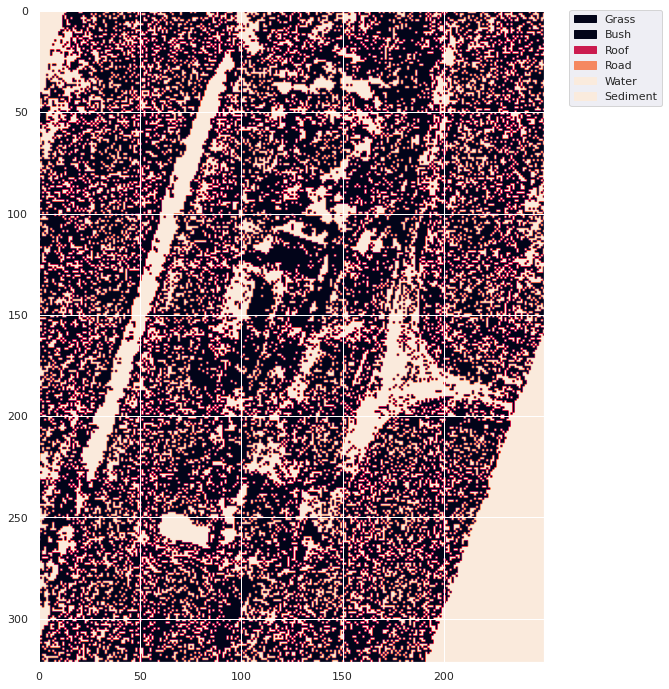

In [ ]:
plot_predict(final_pred_RGBDSM)

In [ ]:
print(f'The global acc of prediction is: {accuracy}') 

The global acc of prediction is: 0.8071065989847716


In [ ]:
labels = ['Grass', 'Bush', 'Tree', 'Roof', 'Road', 'Water', 'Sediment']
df_cm = pd.DataFrame(cm, index = labels,
                  columns = labels)
df_cm

Grass  Bush  Tree  Roof  Road  Water  Sediment
Grass       224    15     0     1     0      0         0
Bush         38    88     0     6     1     10         8
Tree          3     2     0     2     0      1         0
Roof          3     6     0   114     0      0         3
Road          0     0     0     0    66      0        15
Water         0    15     0     1     0     68         0
Sediment      0     7     0     1    12      2        76

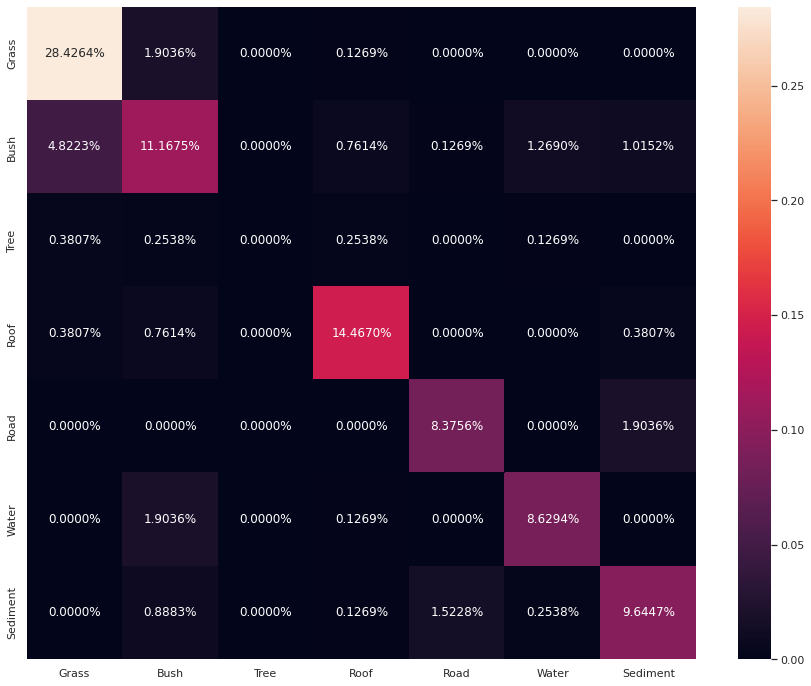

In [ ]:
plt.figure(figsize = (15, 12))
sns.heatmap(df_cm/np.sum(cm), fmt='.4%', annot=True)

#### **Test Gradient Boost Model on the RedEdge + DSM stack**

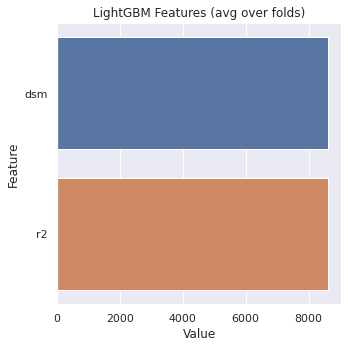

In [ ]:
#1. Create dataset
# available: ["r", "g", "b", "nir", "dsm", "r2"]
X_train, X_test, y_train, y_test = create_dataset(bands = "dsm+r2")

# 2. Evaluate your model in local (using ligthgbm)
model, accuracy, cm = train_test_model(X_train, X_test, y_train, y_test)

# 3. Evaluate your model using ligthgbm
plotImp(model, X_train, num = 10, fig_size = (5, 5))

# 4. Predict
final_pred_RE_DSM = Predict(model)

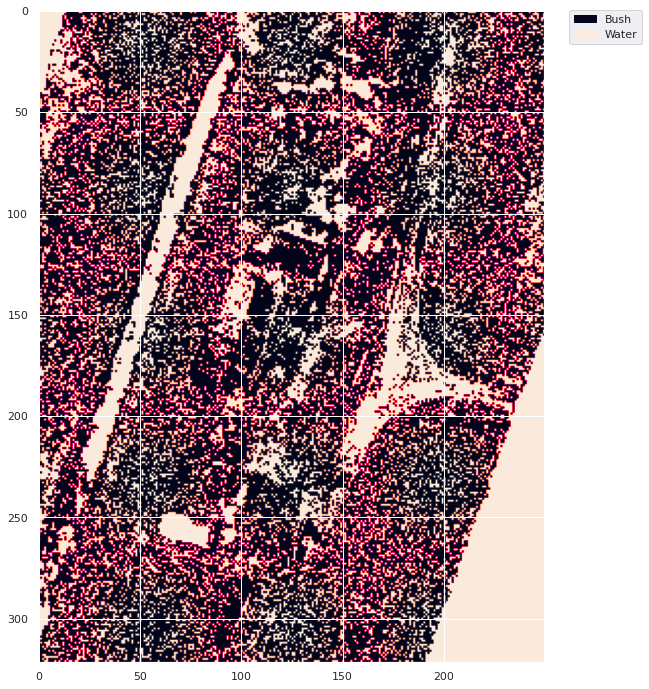

In [ ]:
plot_predict(final_pred_RE_DSM)

In [ ]:
print(f'The global acc of prediction is: {accuracy}') 

The global acc of prediction is: 0.5913705583756346


In [ ]:
labels = ['Grass', 'Bush', 'Tree', 'Roof', 'Road', 'Water', 'Sediment']
df_cm = pd.DataFrame(cm, index = labels,
                  columns = labels)
df_cm

Grass  Bush  Tree  Roof  Road  Water  Sediment
Grass       208     7     0    12     6      0         7
Bush         38    63     1    15     4     19        11
Tree          3     4     0     1     0      0         0
Roof         58    24     0    16     6      4        18
Road          3     1     0     4    66      0         7
Water         0    11     0     1     1     71         0
Sediment     25    11     0    11     8      1        42

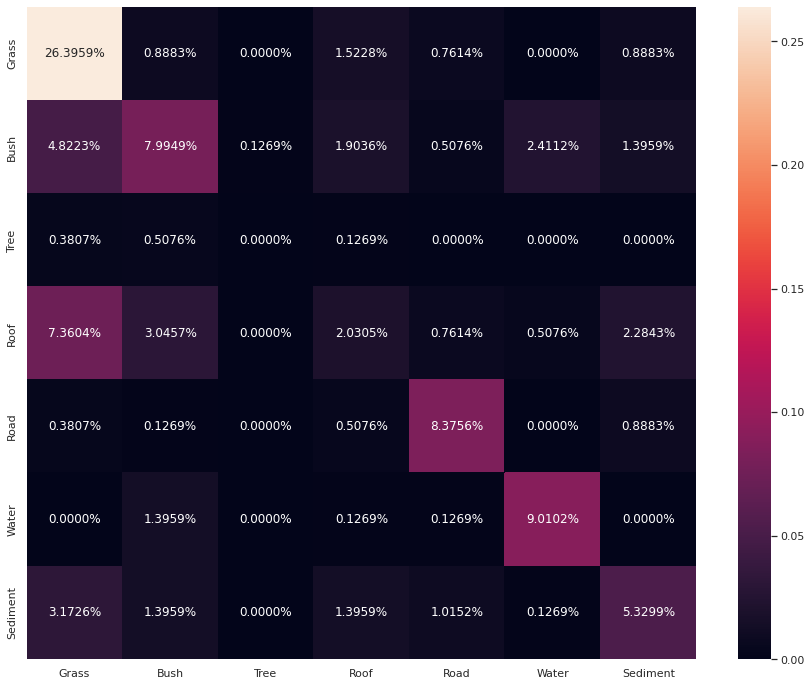

In [ ]:
plt.figure(figsize = (15, 12))
sns.heatmap(df_cm/np.sum(cm), fmt='.4%', annot=True)

#### **Test Gradient Boost Model on the RGB + RedEdge stack**

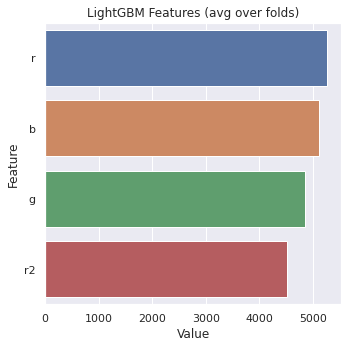

In [ ]:
#1. Create dataset
# available: ["r", "g", "b", "nir", "dsm", "r2"]
X_train, X_test, y_train, y_test = create_dataset(bands = "r+g+b+r2")

# 2. Evaluate your model in local (using ligthgbm)
model, accuracy, cm = train_test_model(X_train, X_test, y_train, y_test)

# 3. Evaluate your model using ligthgbm
plotImp(model, X_train, num = 10, fig_size = (5, 5))

# 4. Predict
final_pred_RGBRE = Predict(model)

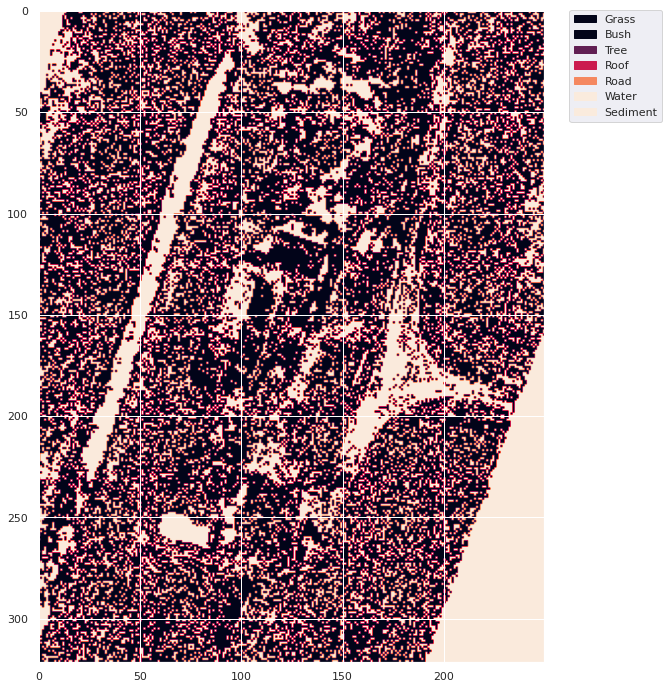

In [ ]:
plot_predict(final_pred_RGBRE)

In [ ]:
print(f'The global acc of prediction is: {accuracy}') 

The global acc of prediction is: 0.8299492385786802


In [ ]:
labels = ['Grass', 'Bush', 'Tree', 'Roof', 'Road', 'Water', 'Sediment']
df_cm = pd.DataFrame(cm, index = labels,
                  columns = labels)
df_cm

Grass  Bush  Tree  Roof  Road  Water  Sediment
Grass       226    12     2     0     0      0         0
Bush         23    99     1     8     1     12         7
Tree          4     3     0     1     0      0         0
Roof          2     7     0   114     0      0         3
Road          0     0     0     0    69      0        12
Water         0    11     0     0     0     72         1
Sediment      0    10     0     1    12      1        74

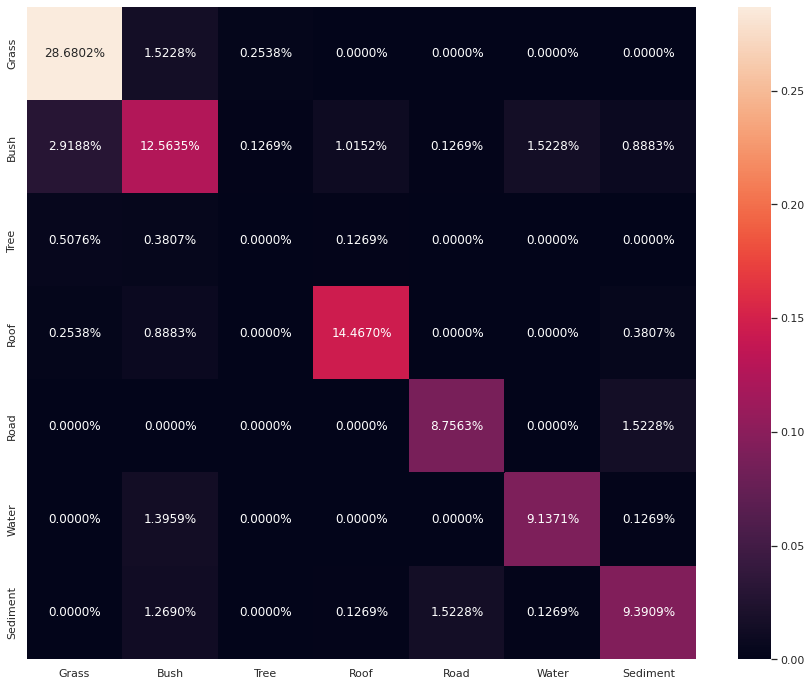

In [ ]:
plt.figure(figsize = (15, 12))
sns.heatmap(df_cm/np.sum(cm), fmt='.4%', annot=True)

#### **Test Gradient Boost Model on the RGB+NIR+RedEdge stack**

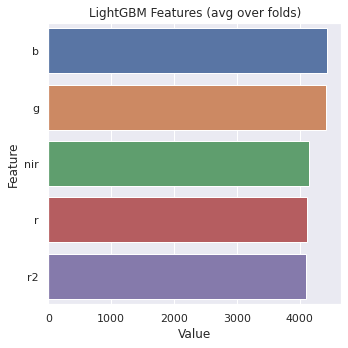

In [ ]:
#1. Create dataset
# available: ["r", "g", "b", "nir", "dsm", "r2"]
X_train, X_test, y_train, y_test = create_dataset(bands = "r+g+b+nir+r2")

# 2. Evaluate your model in local (using ligthgbm)
model, accuracy, cm = train_test_model(X_train, X_test, y_train, y_test)

# 3. Evaluate your model using ligthgbm
plotImp(model, X_train, num = 10, fig_size = (5, 5))

# 4. Predict
final_pred_RGBNIRRE = Predict(model)

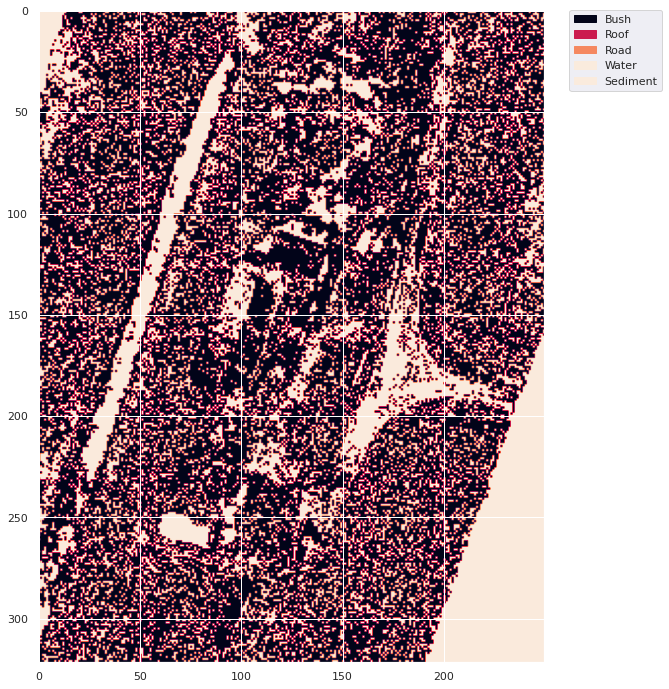

In [ ]:
plot_predict(final_pred_RGBNIRRE)

In [ ]:
print(f'The global acc of prediction is: {accuracy}') 

The global acc of prediction is: 0.8629441624365483


In [ ]:
labels = ['Grass', 'Bush', 'Tree', 'Roof', 'Road', 'Water', 'Sediment']
df_cm = pd.DataFrame(cm, index = labels,
                  columns = labels)
df_cm

Grass  Bush  Tree  Roof  Road  Water  Sediment
Grass       233     6     0     1     0      0         0
Bush         21   108     1     8     1      8         4
Tree          5     3     0     0     0      0         0
Roof          2     6     0   116     0      1         1
Road          0     1     0     0    70      1         9
Water         0     7     0     0     0     76         1
Sediment      0     7     0     1    12      1        77

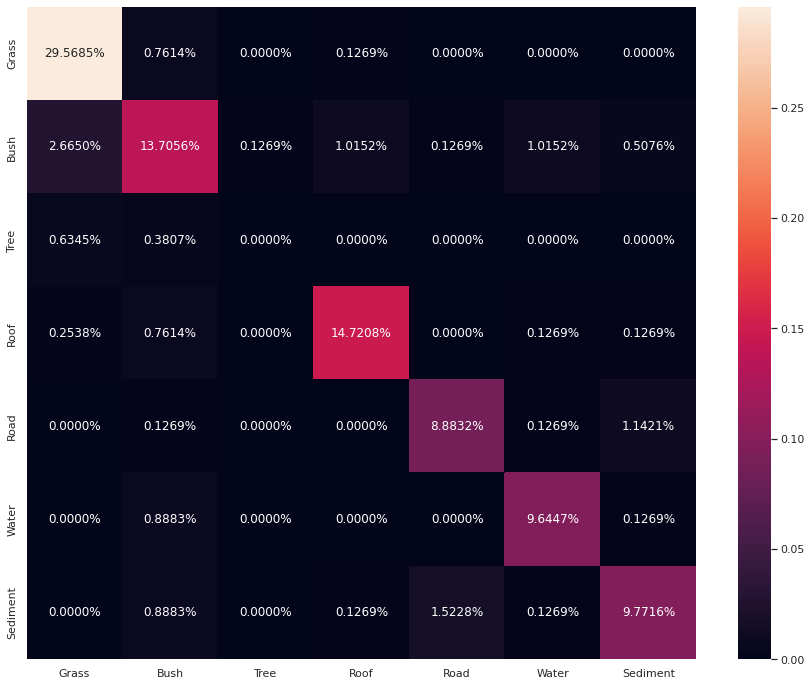

In [ ]:
plt.figure(figsize = (15, 12))
sns.heatmap(df_cm/np.sum(cm), fmt='.4%', annot=True)

### **7. Display all predictions**

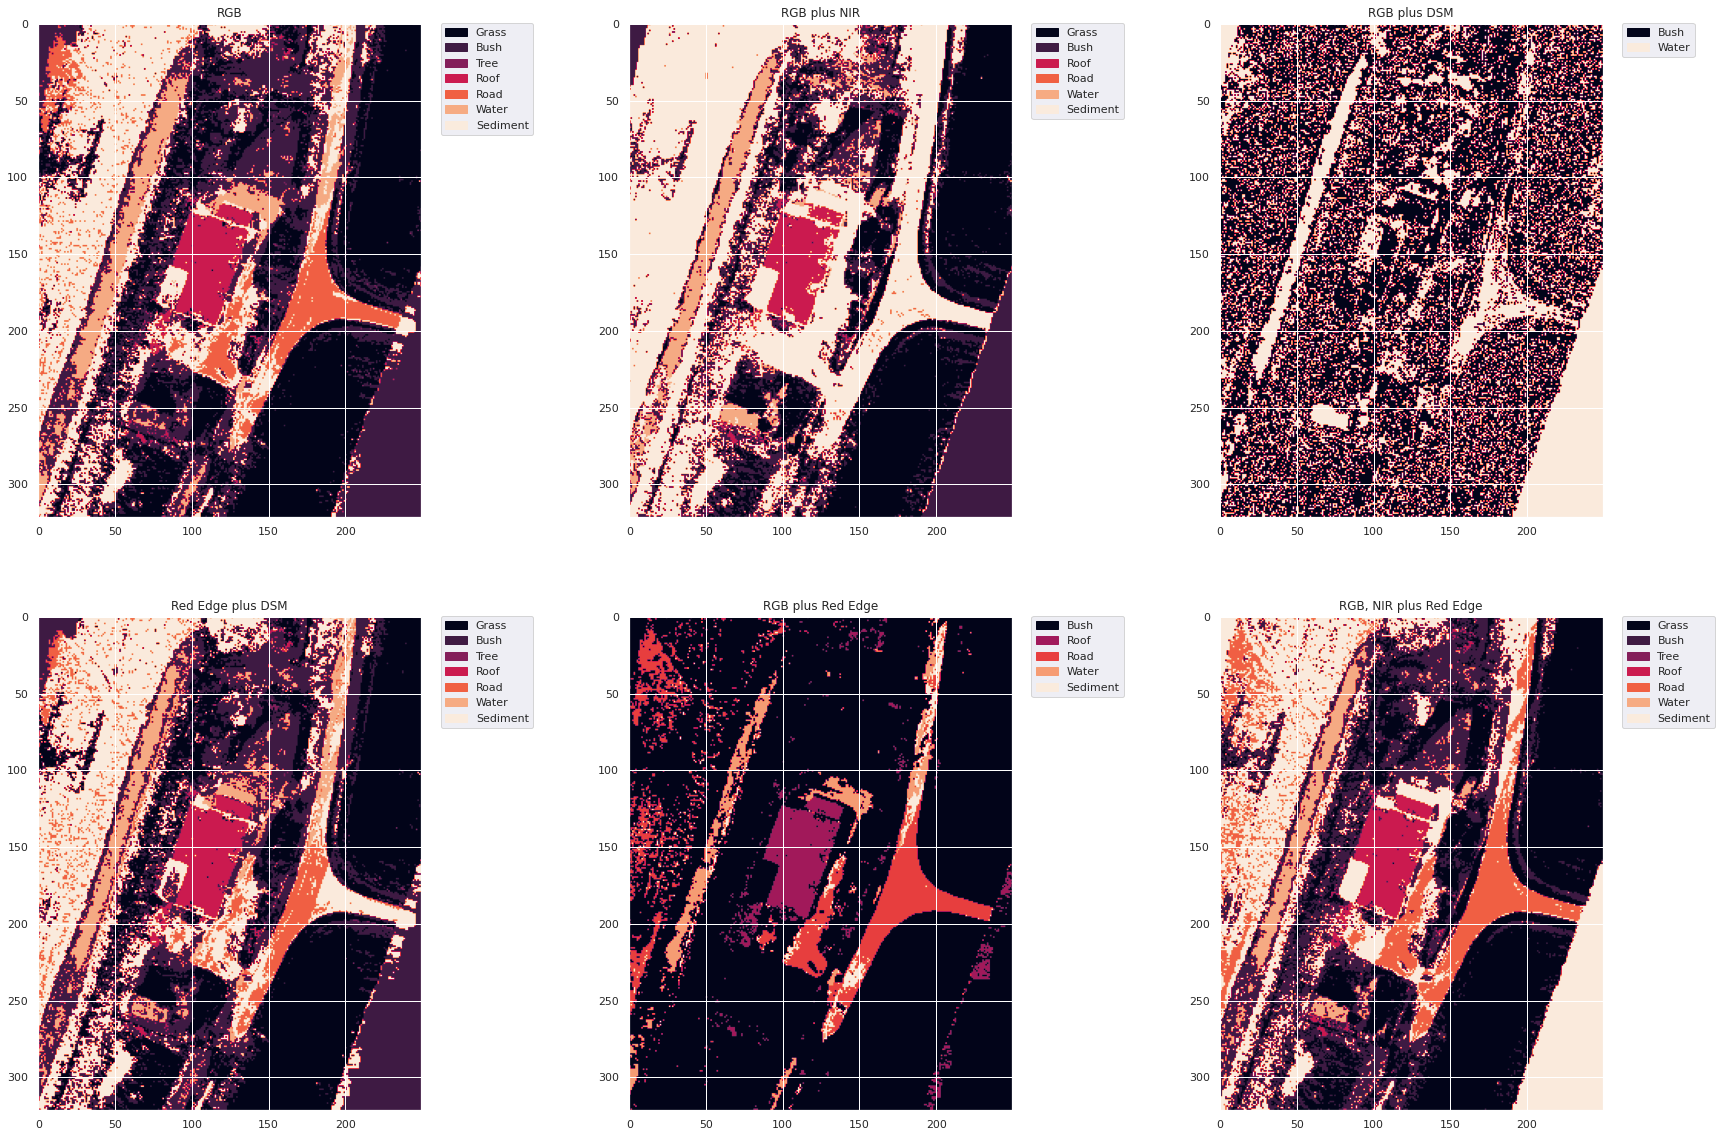

In [ ]:
all_predictions = [final_pred_RGB, final_pred_RGBNIR, final_pred_RGBDSM, final_pred_RE_DSM, final_pred_RGBRE,  final_pred_RGBNIRRE]
titles = ["RGB", "RGB plus NIR", "RGB plus DSM", "Red Edge plus DSM", "RGB plus Red Edge", "RGB, NIR plus Red Edge"]

fig, axs = plt.subplots(2, 3, figsize = (30, 20))

for i, ax, title in zip(range(len(all_predictions)), axs.ravel(), titles):
  values = np.unique(all_predictions[i].ravel())
  classes = {0: 'Grass', 1: 'Bush', 2: 'Tree', 3: 'Roof', 4: 'Road', 5: 'Water', 6: 'Sediment'}
  final_classes = [i for i in [classes[i] for i in values] ]
  im = plt.imshow((all_predictions[i]))
  colors = [im.cmap(im.norm(value)) for value in values]
  patches = [ mpatches.Patch(color=colors[i], label="{l}".format(l=final_classes[i]) ) for i in range(len(final_classes))]
  plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0. )
  plt.sca(ax)
  plt.title(f"{title}")

### **Conclusion**
In this analysis, we have implemented the Gradient Boost Machine on a sets of image stacks, obtained from different imaging sensors, and tested their relative performances by showing their accuracies and confusion matrix.

The best overall performance in terms of recorded model accuracy ***(86%)*** and visual evaluation of the class discrimination was observed in the band stacks of RGB, NIR and Red Edge Band combination. However, the tree class was missed in almost all the image classes, due to the limited number of samples in the image scene and the train labeled datasets (shown in section 4 of this notebook). The Red Edge and NIR layer effectively helped in identifying the sediments properly but misclassified water significantly. The DSM layer, when combined with the Red Edge layer, effectively identified surfaces above ground like the roof top but misclassified roads as sediments. When combined with the RGB layer, however, it only helps in identifying the Bush and water targets.

In all cases, the Gradient Boost Machine shows that the Red, Green and Blue bands are the most important features for classifying the imaged scene and worked as an effective algorithm for performing image scene classification in an effective manner. 